<a href="https://colab.research.google.com/github/shivesh2334-ai/Display-board-emc/blob/main/ECG_data_pipeline_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complete ECG Analysis Pipeline for Google Colab
 Run this step by step in separate cells

============================================================================
 CELL 1: Install Required Packages and Setup
# ======

In [ ]:
!pip install wfdb tensorflow scikit-learn matplotlib seaborn pandas numpy scipy
!pip install requests zipfile36


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print("Setup completed!")


Setup completed!


============================================================================
 CELL 2: Download and Setup Sample ECG Data (Since PTB-XL is large)
 ============================================================================

 For Colab demo, we'll create synthetic ECG data similar to PTB-XL format
In real implementation, you would download the actual PTB-XL dataset


In [ ]:
def create_synthetic_ecg_data(n_samples=1000, n_leads=12, length=1000):
    """
    Create synthetic ECG data for demonstration
    In real implementation, replace this with actual PTB-XL data loading
    """
    np.random.seed(42)

    # Generate synthetic ECG signals with different patterns
    X = []
    y = []

    for i in range(n_samples):
        # Create base ECG pattern
        t = np.linspace(0, 10, length)  # 10 seconds

        # Simulate 12-lead ECG with different characteristics
        ecg_12_lead = []

        for lead in range(n_leads):
            # Base sinusoidal pattern with noise
            base_freq = 1.2 + np.random.normal(0, 0.1)  # Heart rate variation
            ecg_signal = np.sin(2 * np.pi * base_freq * t) + \
                        0.3 * np.sin(2 * np.pi * base_freq * 2 * t) + \
                        0.1 * np.random.normal(0, 1, length)

            # Add lead-specific variations
            ecg_signal *= (0.5 + 0.5 * np.random.random())
            ecg_signal += 0.1 * np.random.normal(0, 1, length)

            ecg_12_lead.append(ecg_signal)

        X.append(np.array(ecg_12_lead).T)  # Shape: (1000, 12)

        # Create synthetic labels (5 classes: Normal, MI, STTC, CD, HYP)
        label = np.zeros(5)
        # Randomly assign conditions (can be multi-label)
        if np.random.random() > 0.7:  # 30% abnormal
            abnormal_conditions = np.random.choice([1, 2, 3, 4],
                                                 size=np.random.randint(1, 3))
            label[abnormal_conditions] = 1
        else:
            label[0] = 1  # Normal

        y.append(label)

    return np.array(X), np.array(y)

# Generate synthetic data
print("Generating synthetic ECG data...")
X_data, y_data = create_synthetic_ecg_data(n_samples=2000)

print(f"Data shape: X={X_data.shape}, y={y_data.shape}")
print(f"Label distribution:")
class_names = ['Normal', 'MI', 'STTC', 'CD', 'HYP']
for i, name in enumerate(class_names):
    count = np.sum(y_data[:, i])
    print(f"  {name}: {count} samples ({count/len(y_data)*100:.1f}%)")



Generating synthetic ECG data...
Data shape: X=(2000, 1000, 12), y=(2000, 5)
Label distribution:
  Normal: 1403.0 samples (70.2%)
  MI: 209.0 samples (10.4%)
  STTC: 206.0 samples (10.3%)
  CD: 206.0 samples (10.3%)
  HYP: 187.0 samples (9.3%)


CELL 3: Data Preprocessing

In [ ]:
class ECGPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.fitted = False

    def preprocess_signals(self, X):
        """Preprocess ECG signals"""
        X_processed = []

        for i in range(len(X)):
            # Normalize each lead separately
            signal = X[i].copy()

            # Z-score normalization for each lead
            for lead in range(signal.shape[1]):
                lead_data = signal[:, lead]
                signal[:, lead] = (lead_data - np.mean(lead_data)) / (np.std(lead_data) + 1e-8)

            X_processed.append(signal)

        return np.array(X_processed)

    def fit_transform(self, X):
        """Fit preprocessor and transform data"""
        self.fitted = True
        return self.preprocess_signals(X)

    def transform(self, X):
        """Transform data using fitted preprocessor"""
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted first")
        return self.preprocess_signals(X)


In [ ]:
preprocessor = ECGPreprocessor()
X_processed = preprocessor.fit_transform(X_data)



In [ ]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y_data, test_size=0.4, random_state=42, stratify=y_data[:, 0]
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp[:, 0]
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")


Training set: (1200, 1000, 12)
Validation set: (400, 1000, 12)
Test set: (400, 1000, 12)


# CELL 4: Model Definition

In [ ]:
def create_ecg_model(input_shape=(1000, 12), num_classes=5):
    """Create CNN model for ECG classification"""

    model = models.Sequential([
        # First convolutional block
        layers.Conv1D(64, 15, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),

        # Second convolutional block
        layers.Conv1D(128, 15, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),

        # Third convolutional block
        layers.Conv1D(256, 15, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),

        # Fourth convolutional block
        layers.Conv1D(512, 15, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.4),

        # Dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Output layer (multi-label classification)
        layers.Dense(num_classes, activation='sigmoid')
    ])

    return model

In [ ]:
# Create and compile model
model = create_ecg_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 986, 64)        │        11,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 986, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 493, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 493, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 479, 128)       │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 479, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 239, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 239, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 225, 256)       │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 225, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 112, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 112, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 98, 512)        │     1,966,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 98, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761,669 (10.53 MB)

 Trainable params: 2,759,749 (10.53 MB)

 Non-trainable params: 1,920 (7.50 KB)

# CELL 5: Model Training

In [ ]:
# Define callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_ecg_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Reduced for demo
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("Training completed!")

Starting model training...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5455 - loss: 0.4916 - precision: 0.5406 - recall: 0.4479
Epoch 1: val_loss improved from inf to 0.42127, saving model to best_ecg_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5482 - loss: 0.4903 - precision: 0.5432 - recall: 0.4501 - val_accuracy: 0.7025 - val_loss: 0.4213 - val_precision: 0.7025 - val_recall: 0.6272 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7076 - loss: 0.3942 - precision: 0.7162 - recall: 0.6132
Epoch 2: val_loss improved from 0.42127 to 0.40921, saving model to best_ecg_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7075 - loss: 0.3945 - precision: 0.7160 - recall: 0.6129 - val_accuracy: 0.7025 - val_loss: 0.4092 - val_precision: 0.7025 - val_recall: 0.6272 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6957 - loss: 0.3866 - precision: 0.7015 - recall: 0.6029
Epoch 3: val_loss improved from 0.40921 to 0.40615, saving model to best_ecg_model.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6958 - loss: 0.3866 - precision: 0.7016 - recall: 0.6031 - val_accuracy: 0.7025 - val_loss: 0.4061 - val_precision: 0.7018 - val_recall: 0.6250 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6823 - loss: 0.3842 - precision: 0.6908 - recall: 0.5901
Epoch 4: val_loss did not improve from 0.40615
38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.6828 - loss: 0.3841 - precision: 0.6913 - recall: 0.5906 - val_accuracy: 0.7025 - val_loss: 0.4142 - val_precision: 0.7008 - val_recall: 0.6116 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7183 - loss: 0.3539 - precision: 0.7305 - recall: 0.6288
Epoch 5: val_loss did not improve from 0.40615
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7179 - loss: 0.3543 - precision: 0.7301 - recall: 0.6285 - val_accuracy: 0.7025 - val_loss: 0.4391 - val_precision: 0.7030 - val_recall: 0.6183 - learning_rate: 0.0010
Ep

In [ ]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()


# CELL 7: ECG Analysis Application Class

In [ ]:
class ECGAnalysisApp:
    def __init__(self, model, preprocessor):
        self.model = model
        self.preprocessor = preprocessor
        self.class_names = ['Normal', 'Myocardial Infarction', 'ST/T Change',
                           'Conduction Disturbance', 'Hypertrophy']
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
                          'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    def analyze_ecg(self, ecg_data, patient_info=None):
        """Analyze ECG data and return comprehensive results"""

        # Ensure correct shape
        if len(ecg_data.shape) == 2:
            ecg_data = np.expand_dims(ecg_data, axis=0)

        # Preprocess
        ecg_processed = self.preprocessor.transform(ecg_data)

        # Predict
        predictions = self.model.predict(ecg_processed, verbose=0)[0]

        # Create results
        results = {
            'patient_info': patient_info or {},
            'predictions': {},
            'risk_assessment': self._assess_risk(predictions),
            'recommendations': self._generate_recommendations(predictions)
        }

        # Add prediction details
        for i, class_name in enumerate(self.class_names):
            results['predictions'][class_name] = {
                'probability': float(predictions[i]),
                'classification': 'Positive' if predictions[i] > 0.5 else 'Negative',
                'confidence': self._calculate_confidence(predictions[i])
            }

        return results

    def _assess_risk(self, predictions):
        """Assess overall cardiac risk"""
        risk_score = 0

        if predictions[1] > 0.5:  # MI
            risk_score += 5
        if predictions[2] > 0.5:  # ST/T changes
            risk_score += 3
        if predictions[3] > 0.5:  # Conduction disturbance
            risk_score += 2
        if predictions[4] > 0.5:  # Hypertrophy
            risk_score += 2

        if risk_score >= 5:
            return {'level': 'High', 'score': risk_score}
        elif risk_score >= 2:
            return {'level': 'Moderate', 'score': risk_score}
        else:
            return {'level': 'Low', 'score': risk_score}

    def _generate_recommendations(self, predictions):
        """Generate clinical recommendations"""
        recommendations = []

        if predictions[1] > 0.5:  # MI
            recommendations.append("Immediate cardiology consultation recommended")
        if predictions[2] > 0.5:  # ST/T changes
            recommendations.append("Monitor for ischemic changes")
        if predictions[3] > 0.5:  # Conduction disturbance
            recommendations.append("Monitor heart rhythm continuously")
        if predictions[4] > 0.5:  # Hypertrophy
            recommendations.append("Consider echocardiogram")

        if not any(pred > 0.5 for pred in predictions[1:]):
            recommendations.append("Normal ECG - routine follow-up")

        return recommendations

    def _calculate_confidence(self, probability):
        """Calculate confidence level"""
        if probability > 0.8 or probability < 0.2:
            return 'High'
        elif probability > 0.65 or probability < 0.35:
            return 'Moderate'
        else:
            return 'Low'

    def visualize_ecg(self, ecg_data, title="ECG Analysis"):
        """Visualize 12-lead ECG"""
        fig, axes = plt.subplots(4, 3, figsize=(15, 12))
        axes = axes.flatten()

        for i in range(12):
            axes[i].plot(ecg_data[:, i])
            axes[i].set_title(f'Lead {self.lead_names[i]}')
            axes[i].set_xlabel('Time (samples)')
            axes[i].set_ylabel('Amplitude')
            axes[i].grid(True)

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()


# CELL 8: Demo Usage

ECG Analysis Demo
Analyzing test sample 371
True labels: ['MI']

Analysis Results:
------------------------------
✓ Normal: 0.825 (High confidence)
✗ Myocardial Infarction: 0.074 (High confidence)
✗ ST/T Change: 0.076 (High confidence)
✗ Conduction Disturbance: 0.040 (High confidence)
✗ Hypertrophy: 0.068 (High confidence)

Risk Assessment: Low Risk
Risk Score: 0

Recommendations:
• Normal ECG - routine follow-up


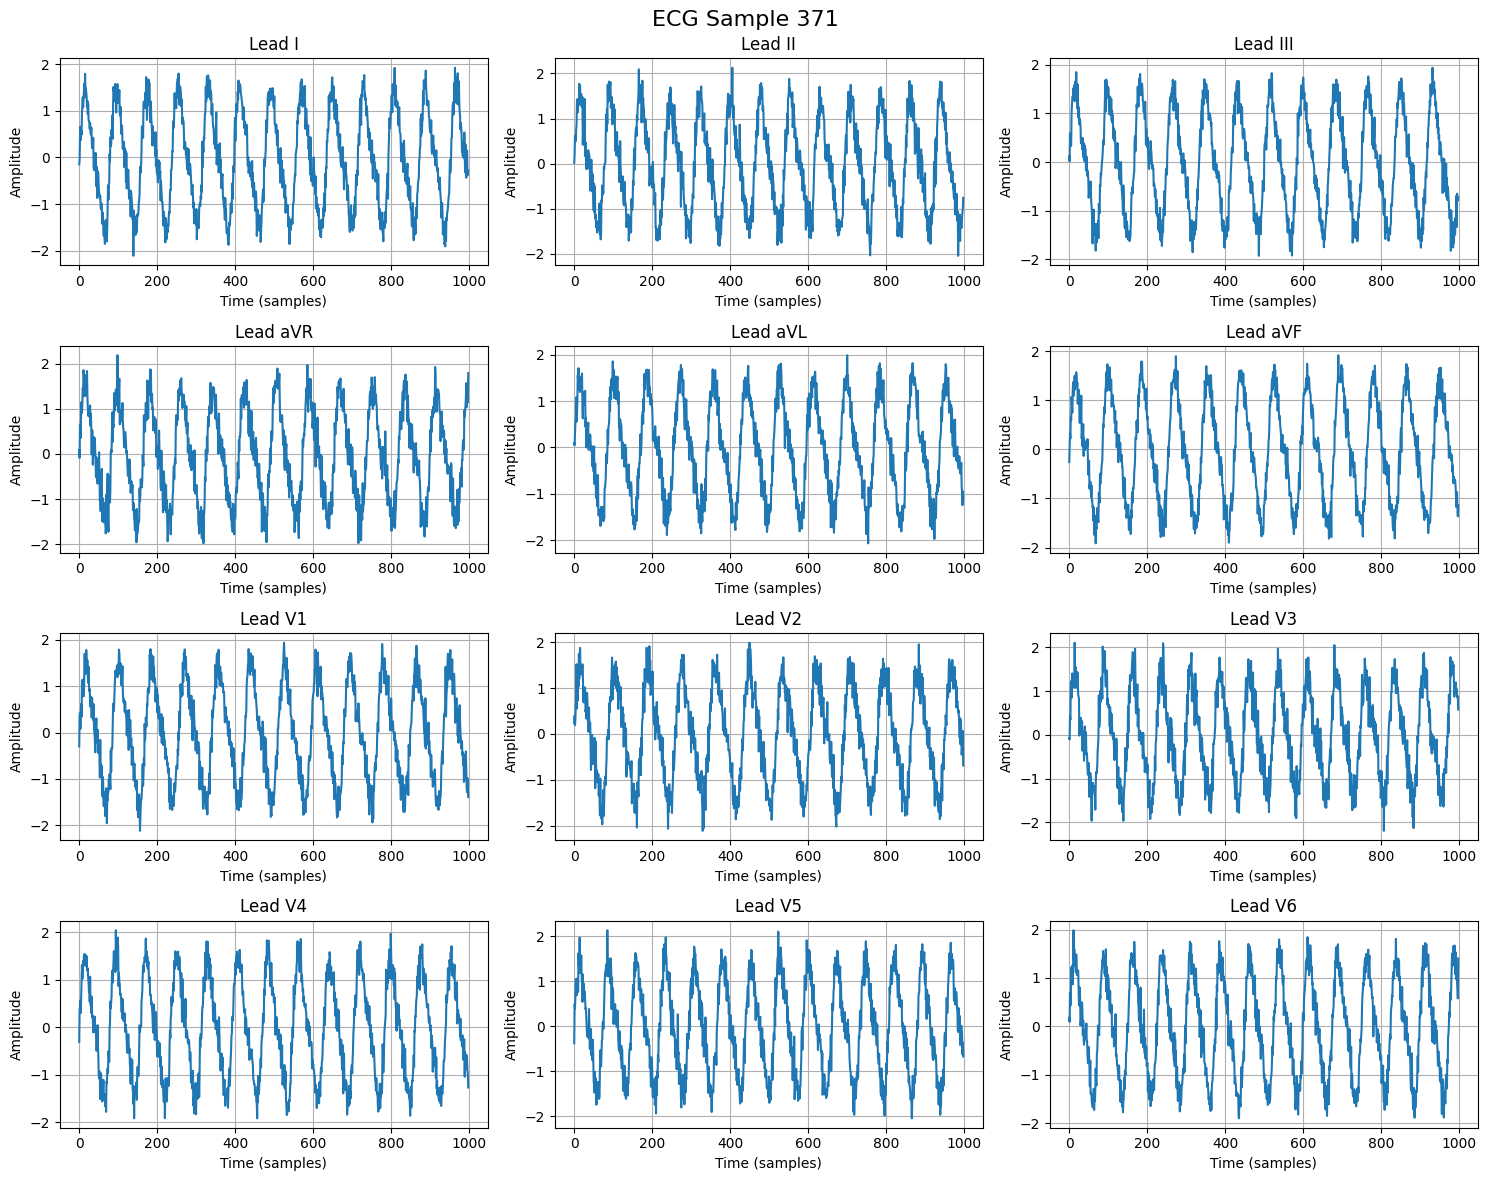


Setup Complete! The model is now trained and ready to use.
You can now use the ECGAnalysisApp class to analyze new ECG data.


In [ ]:
# Initialize the ECG analyzer with trained model
ecg_analyzer = ECGAnalysisApp(model, preprocessor)

# Demo with test sample
print("ECG Analysis Demo")
print("="*50)

# Select a random test sample
sample_idx = np.random.randint(0, len(X_test))
sample_ecg = X_test[sample_idx]
true_labels = y_test[sample_idx]

print(f"Analyzing test sample {sample_idx}")
print(f"True labels: {[class_names[i] for i, val in enumerate(true_labels) if val == 1]}")

# Analyze the ECG
results = ecg_analyzer.analyze_ecg(sample_ecg,
                                  patient_info={'id': f'patient_{sample_idx}', 'age': 65})

# Display results
print("\nAnalysis Results:")
print("-" * 30)
for condition, result in results['predictions'].items():
    status = "✓" if result['classification'] == 'Positive' else "✗"
    print(f"{status} {condition}: {result['probability']:.3f} ({result['confidence']} confidence)")

print(f"\nRisk Assessment: {results['risk_assessment']['level']} Risk")
print(f"Risk Score: {results['risk_assessment']['score']}")

print("\nRecommendations:")
for rec in results['recommendations']:
    print(f"• {rec}")

# Visualize the ECG
ecg_analyzer.visualize_ecg(sample_ecg, f"ECG Sample {sample_idx}")

print("\n" + "="*50)
print("Setup Complete! The model is now trained and ready to use.")
print("You can now use the ECGAnalysisApp class to analyze new ECG data.")

In [ ]:
# Install Gradio
!pip install gradio

import gradio as gr
import numpy as np
import matplotlib.pyplot as plt

# Define the function for Gradio interface
def analyze_uploaded_ecg(ecg_file):
    """Analyzes an uploaded ECG file and returns results and visualization."""

    if ecg_file is None:
        return "Please upload an ECG file.", None, None, None

    try:
        # Assuming the uploaded file is a numpy .npy file
        # For real-world data, you would need to handle various formats (e.g., .mat, .csv)
        ecg_data = np.load(ecg_file.name)

        # Ensure correct shape (samples, leads) - assuming the loaded data is already in this format
        # If your data is in a different shape, you might need to transpose or reshape it
        if ecg_data.shape[1] != 12:
             # Attempt to transpose if leads are in the first dimension
             if ecg_data.shape[0] == 12:
                 ecg_data = ecg_data.T
             else:
                 return f"Uploaded ECG data has shape {ecg_data.shape}. Expected shape (samples, 12).", None, None, None

        print(f"Analyzing uploaded ECG data with shape: {ecg_data.shape}")

        # Use the existing ecg_analyzer instance
        results = ecg_analyzer.analyze_ecg(ecg_data)

        # Format results for display
        predictions_text = "Analysis Results:\n" + "-" * 30 + "\n"
        for condition, result in results['predictions'].items():
            status = "✓" if result['classification'] == 'Positive' else "✗"
            predictions_text += f"{status} {condition}: {result['probability']:.3f} ({result['confidence']} confidence)\n"

        risk_text = f"\nRisk Assessment: {results['risk_assessment']['level']} Risk\n"
        risk_text += f"Risk Score: {results['risk_assessment']['score']}"

        recommendations_text = "\nRecommendations:\n"
        for rec in results['recommendations']:
            recommendations_text += f"• {rec}\n"

        full_results_text = predictions_text + risk_text + recommendations_text

        # Generate visualization (Matplotlib figure)
        fig, axes = plt.subplots(4, 3, figsize=(15, 12))
        axes = axes.flatten()
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

        for i in range(min(ecg_data.shape[1], 12)): # Plot up to 12 leads
            axes[i].plot(ecg_data[:, i])
            axes[i].set_title(f'Lead {lead_names[i]}')
            axes[i].set_xlabel('Time (samples)')
            axes[i].set_ylabel('Amplitude')
            axes[i].grid(True)

        plt.suptitle("Uploaded ECG Visualization", fontsize=16)
        plt.tight_layout()

        return full_results_text, fig, results['risk_assessment']['level'], results['risk_assessment']['score']

    except Exception as e:
        return f"Error processing file: {e}", None, None, None


# Create Gradio interface
iface = gr.Interface(
    fn=analyze_uploaded_ecg,
    inputs=gr.File(label="Upload ECG File (.npy)"),
    outputs=[
        gr.Textbox(label="Analysis Results"),
        gr.Plot(label="ECG Visualization"),
        gr.Textbox(label="Risk Level"),
        gr.Number(label="Risk Score")
    ],
    title="ECG Analysis Demo",
    description="Upload an ECG file (Numpy .npy format, shape: samples x 12 leads) for analysis."
)

# Launch the demo
print("\nLaunching Gradio demo...")
iface.launch()


Launching Gradio demo...
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://57120292fa3ced956b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
